In [5]:
from colour import Color
import eredivisie_nlp as enlp
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statistics import median
from tqdm import tqdm

### Load data

In [6]:
tweets = pd.read_pickle(f"{enlp.determine_root()}/data/raw/tweets_raw.pkl")
tweets = tweets[tweets.lang == 'nl'].reset_index(drop=True)
tweets.hashtag = tweets.hashtag.str.lower()
# The 'users' column contains a dictionary with 23 fields for each user.
# It's probably better to just expand this column into 23 ones with the prefix 'user_'
exp_tweets = pd.concat([tweets, tweets.user.apply(pd.Series).add_prefix("user_")], axis=1)
exp_tweets = exp_tweets.drop(columns = 'user')
# Remove the user__type column, as it has only one value for all items
exp_tweets.drop(['_type', 'user__type'], axis=1, inplace=True)
exp_tweets.shape

(172597, 49)

In [7]:
exp_tweets.columns

Index(['url', 'date', 'content', 'renderedContent', 'id', 'replyCount',
       'retweetCount', 'likeCount', 'quoteCount', 'conversationId', 'lang',
       'source', 'sourceUrl', 'sourceLabel', 'outlinks', 'tcooutlinks',
       'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId',
       'inReplyToUser', 'mentionedUsers', 'coordinates', 'place', 'hashtags',
       'cashtags', 'hashtag', 'user_username', 'user_id', 'user_displayname',
       'user_description', 'user_rawDescription', 'user_descriptionUrls',
       'user_verified', 'user_created', 'user_followersCount',
       'user_friendsCount', 'user_statusesCount', 'user_favouritesCount',
       'user_listedCount', 'user_mediaCount', 'user_location',
       'user_protected', 'user_linkUrl', 'user_linkTcourl',
       'user_profileImageUrl', 'user_profileBannerUrl', 'user_label',
       'user_url'],
      dtype='object')

# General statistics of type of tweets

In [8]:
print(f"Number of retweets: {len([rt for rt in exp_tweets['retweetedTweet'] if not np.isnan(rt)])}")
print(f"Number of replies: {len([rt for rt in exp_tweets['inReplyToTweetId'] if not np.isnan(rt)])}")
print(f"Number of tweets quoting another: {len([rt for rt in exp_tweets['quotedTweet'] if type(rt) == dict])}")
print(f"Number of tweets with coordinates: {len([rt for rt in exp_tweets['coordinates'] if type(rt) == dict])}")

Number of retweets: 0
Number of replies: 6502
Number of tweets quoting another: 5860
Number of tweets with coordinates: 10050


In [9]:
print(f"Overlap between replying and quoting tweets: {len([quote for quote, reply in zip(exp_tweets['quotedTweet'], exp_tweets['inReplyToTweetId']) if type(quote) == dict and type(reply) == dict])}")

Overlap between replying and quoting tweets: 0


# Plot temporal distribution of tweets
Done:
1. Basic boxplots showing distribution of # of tweets before, during, and after match

In [10]:
# load data files
df = pd.read_pickle(f"{enlp.determine_root()}/data/master_annotations.pkl")
grades = pd.read_csv(enlp.determine_root() + "/data/grades.csv", index_col=[0])

# lowercase GAE for Go Ahead Eagles
df['hashtag'] = df['hashtag'].str.lower()

# get set of hashtags to iterate over
hashtags = [tag for tag in list(set(df.hashtag)) if tag in list(set(grades.hashtag))]

# keep track of dataset size per fixture
num_tweets = []

for hashtag in tqdm(hashtags):
    # get playing times
    start_time = pd.to_datetime(grades[grades.hashtag == hashtag].datetime.tolist()[0])
    end_time = start_time + pd.DateOffset(hours=1, minutes=50)  # we assume 5 minutes extra time

    # slice the dataframe on the start and end timestamps
    before = df.loc[(df.hashtag == hashtag) & (df.date < start_time)]
    during = df.loc[(df.hashtag == hashtag) & (df.date > start_time) & (df.date < end_time)]
    after = df.loc[(df.hashtag == hashtag) & (df.date > end_time)]

    # add number of tweets information to list
    num_tweets.append([before.shape[0], during.shape[0], after.shape[0]])

100%|██████████| 204/204 [00:05<00:00, 35.36it/s]


In [11]:
temporal_dist = pd.DataFrame({
    'before': [t[0] for t in num_tweets],
    'during': [t[1] for t in num_tweets],
    'after': [t[2] for t in num_tweets]})

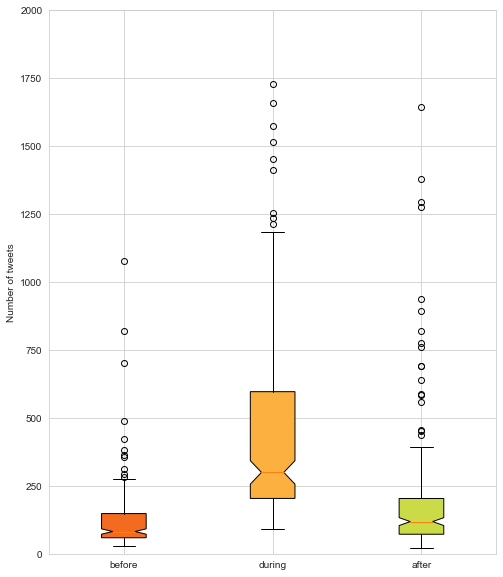

In [12]:
colors = ['#f26b21', '#fbb040', '#cbdb47']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8,10])
bplot = ax.boxplot(temporal_dist, notch=True, labels=temporal_dist.columns, patch_artist=True)
ax.set_ylim([0,2000])
ax.set_ylabel('Number of tweets')
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.savefig(enlp.determine_root() + "/res/figures/befduraft_box.png")
plt.show()

# Distribution of tweets per club
Done:
1. Split number of tweets based on which squad is playing
Ready:
1. This creates three categories of fixtures: both top teams, one top team, both bottom teams. We expect a strong linear connection between # of tweets and league positon/size of fanbase. The Eredivisie standings on February 21, 2022 were: aja, psv, fey, az, twe, vit, utr, nec, cam, gro, hee, her, rkc, gae, for, wil, pec, spa

In [13]:
ranking = ['aja', 'psv', 'fey', 'az', 'twe', 'vit', 'utr', 'nec', 'cam', 'gro', 'hee','her', 'rkc', 'gae', 'for', 'wil', 'pec', 'spa']
tweet_numbers = []
for club in ranking:
    num_tweets = []
    for num, tag in zip(temporal_dist.during, hashtags):
        if club in tag:
            num_tweets.append(num)
    while len(num_tweets) < 23:
        # ensure similar length of columns
        num_tweets.append(False)
    tweet_numbers.append(num_tweets)
club_dist = pd.DataFrame({c: num for c, num in zip(ranking, tweet_numbers)})
club_dist

,aja,psv,fey,az,twe,vit,utr,nec,cam,gro,hee,her,rkc,gae,for,wil,pec,spa
0,1157,570,528,159,2695,1157,363,425,428,368,223,1176,223,248,368,175,420,570
1,2695,428,487,849,323,614,1411,233,159,425,555,91,363,156,175,188,241,487
2,1176,849,4206,248,469,331,420,229,323,614,272,229,528,233,169,306,306,91
3,4206,555,747,241,165,191,1658,240,188,169,596,179,92,420,347,331,191,156
4,1411,707,878,179,319,420,217,323,596,391,323,98,321,272,254,190,357,92
5,960,535,715,321,282,760,220,234,747,357,195,165,177,347,282,878,150,177
6,966,760,1658,254,271,255,403,220,228,300,217,136,98,228,511,240,384,190
7,1134,519,391,469,200,107,160,270,136,328,299,966,230,230,535,1212,217,715
8,835,428,511,707,183,271,158,336,384,284,194,107,319,160,217,349,195,150
9,1212,790,689,1134,256,519,226,839,403,284,658,182,234,182,205,215,255,195


C:\Users\timjo\AppData\Local\Temp/ipykernel_17448/1493525962.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000], size=16)


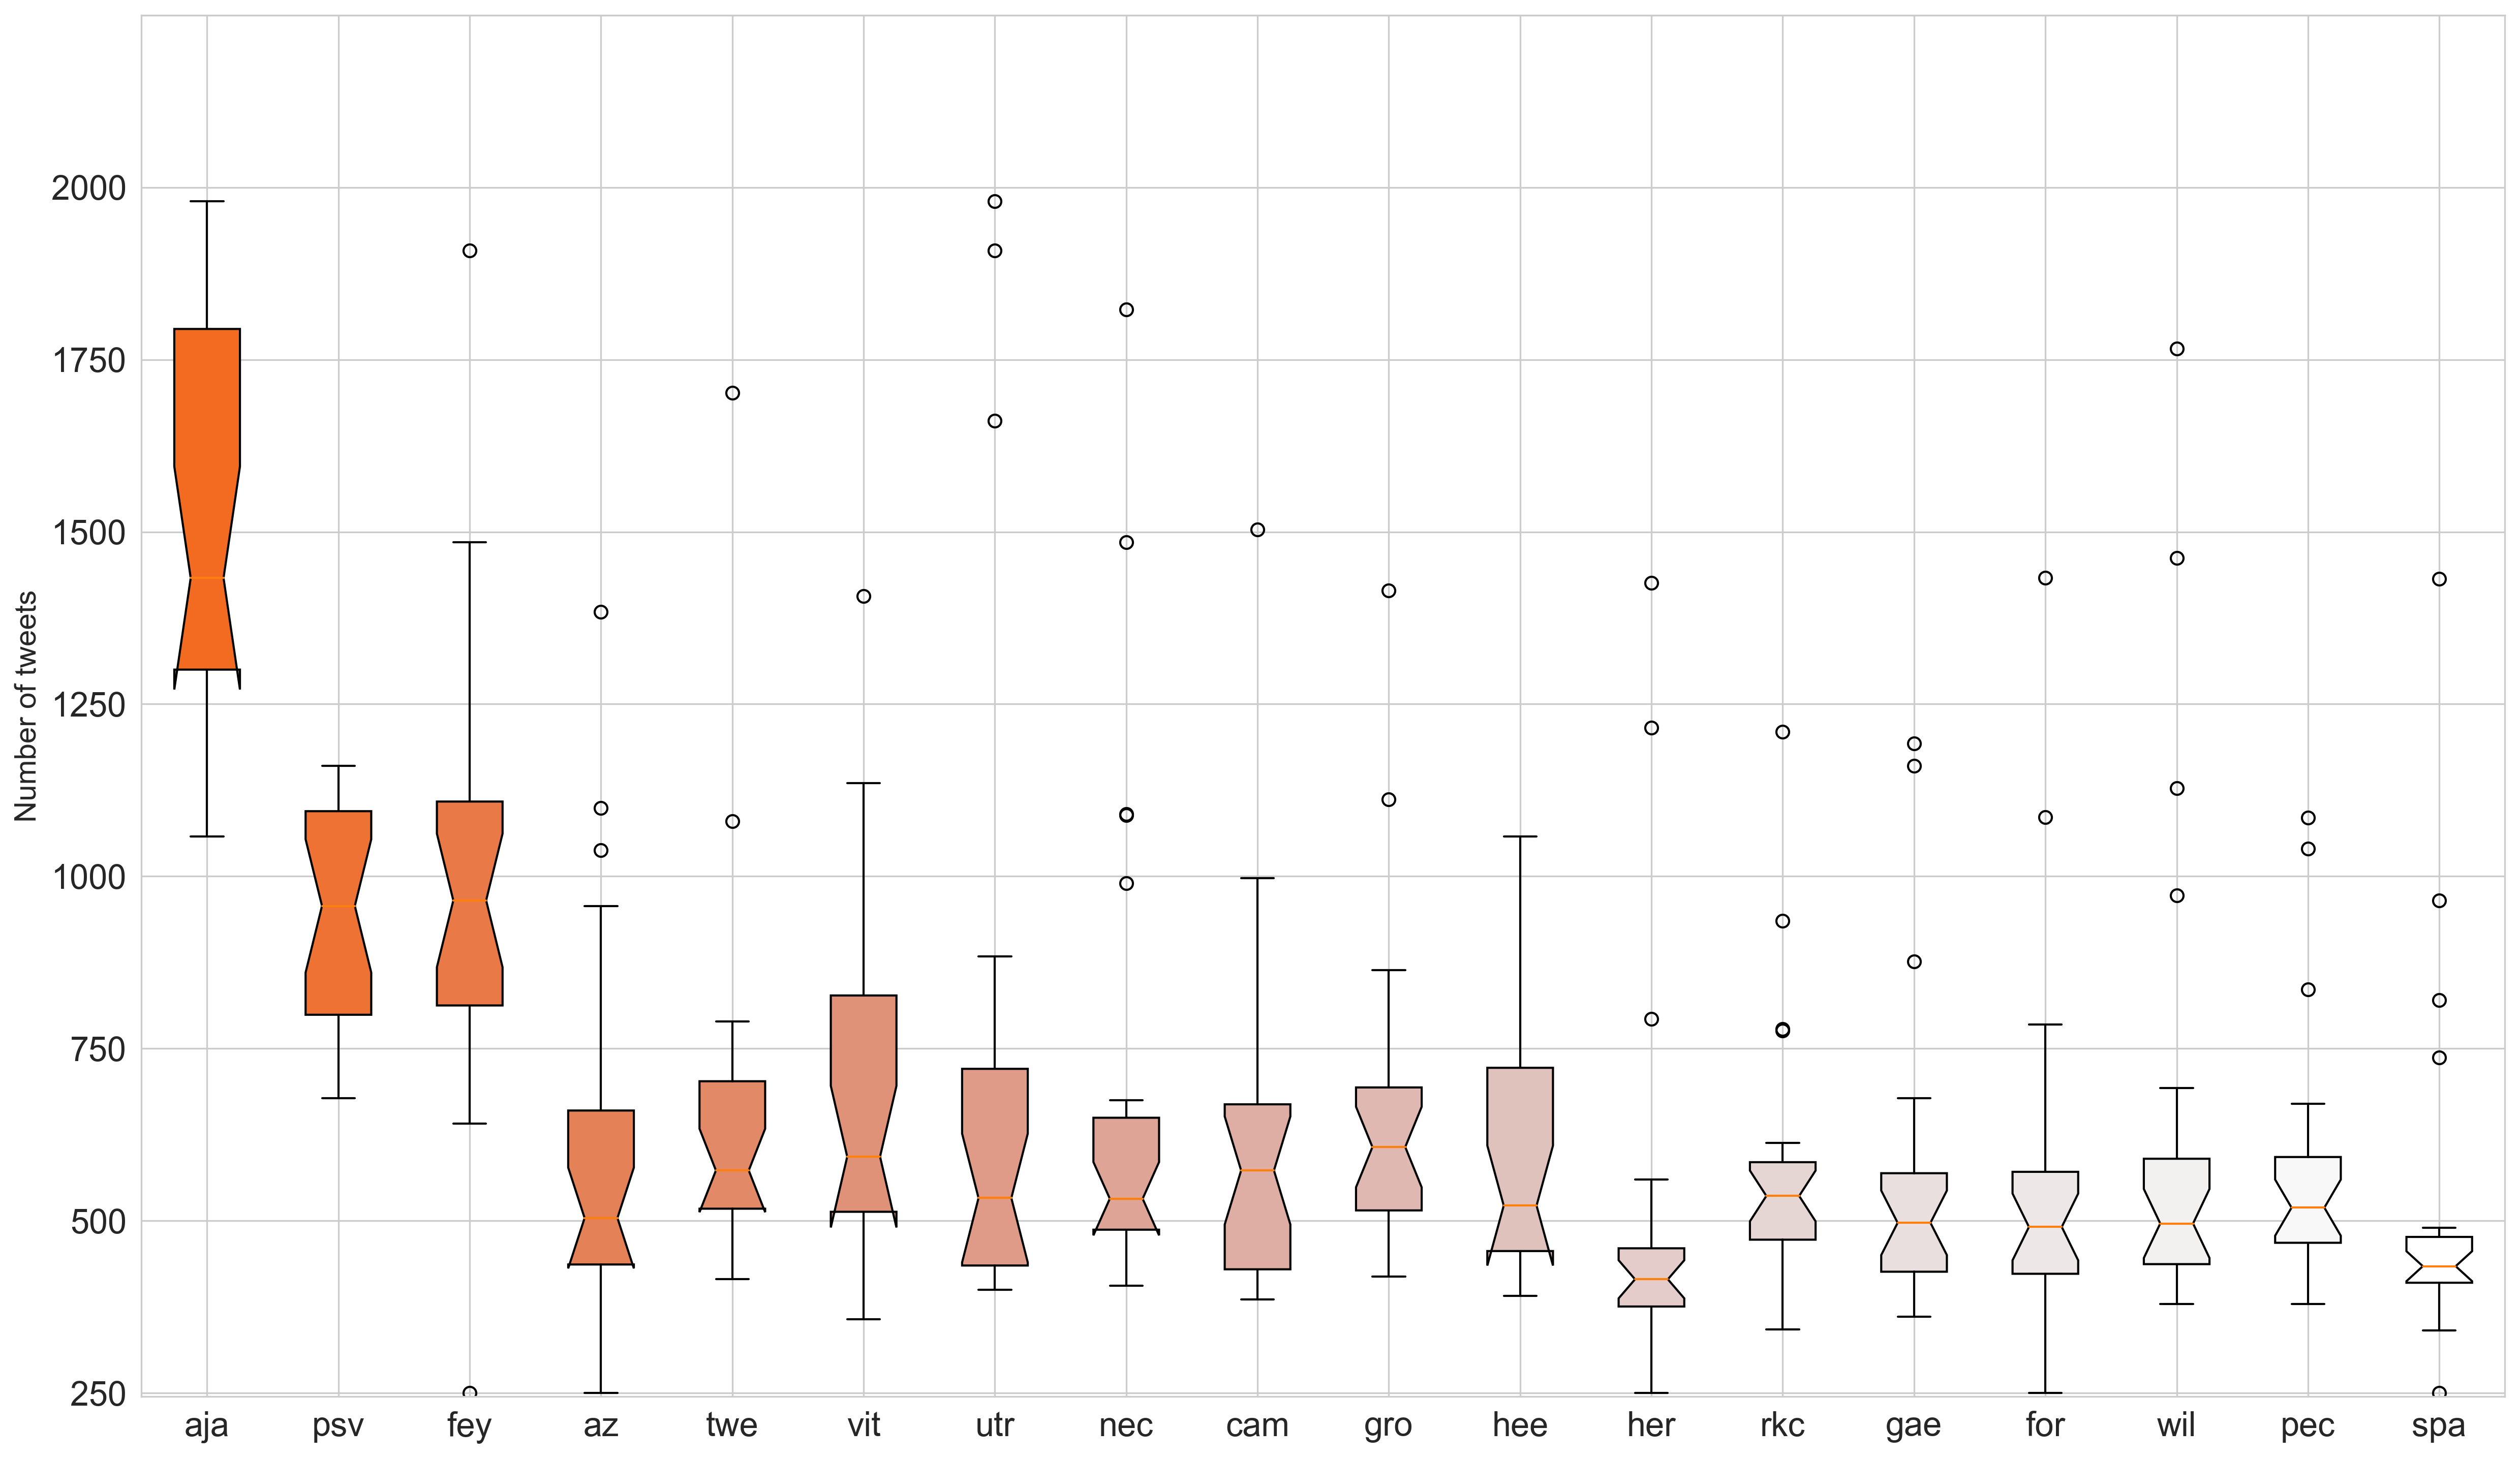

In [14]:
# set color range
orange = Color("#f26b21")
colors = list(orange.range_to(Color('white'), 18))
colors = [c.get_hex() for c in colors]


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[20,12], dpi=300)

bplot = ax1.boxplot(club_dist, notch=True, patch_artist=True)
ax1.set_ylim([-5,2000])
ax1.set_ylabel('Number of tweets', size=14)
ax1.set_xticklabels(club_dist.columns, size=16)
ax1.set_yticklabels([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000], size=16)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.savefig(enlp.determine_root() + "/res/figures/club_tweet_box.png")
plt.show()

In [15]:
temporal_dist['hashtag'] = [h[1:] for h in hashtags]
top_nine = ['aja', 'psv', 'fey', 'az', 'twe', 'vit', 'utr', 'nec', 'cam']
match_type = []
for h in hashtags:
    top = 0
    for tn in top_nine:
        if tn in h:
            top += 1
    match_type.append(top)
temporal_dist['top_9_teams'] = match_type
temporal_dist

,before,during,after,hashtag,top_9_teams
0,171,570,229,psvspa,1
1,57,368,62,forgro,0
2,92,223,68,heerkc,0
3,47,175,54,wilfor,0
4,69,363,163,utrrkc,1
...,...,...,...,...,...
199,49,111,59,hergae,0
200,62,241,41,fornec,1
201,169,862,263,psvgro,1
202,144,539,361,twefey,2


# Geographical map
For bragging rights, but also for testing biases

In [16]:
coords = [c for c in exp_tweets.coordinates if type(c) is dict]

In [17]:
map_hooray = folium.Map(location=[52.0907, 5.1214], zoom_start=9)
heat_data = [[coord['latitude'], coord['longitude']] for coord in coords]
HeatMap(heat_data, radius=15).add_to(map_hooray)
map_hooray

# Number of twitter account per match
How many tweets do we have, per how many twitter accounts?

In [18]:
tweets['user_id'] = [t['id'] for t in tweets.user]
tweets.head(10)

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,hashtag,user_id
0,snscrape.modules.twitter.Tweet,https://twitter.com/jobb024/status/14701674838...,2021-12-12 23:03:37+00:00,Hahahahahah ik ga hier zo goed op. Wat is dit ...,Hahahahahah ik ga hier zo goed op. Wat is dit ...,1470167483848040454,"{'_type': 'snscrape.modules.twitter.User', 'us...",2,0,20,...,"{'_type': 'snscrape.modules.twitter.Tweet', 'u...",NaN,None,None,None,None,[ajaaz],NaN,#ajaaz,777914558610636800
1,snscrape.modules.twitter.Tweet,https://twitter.com/egschiroli/status/14701643...,2021-12-12 22:51:01+00:00,"Het is bijna maandag, kan ik eindelijk bijkome...","Het is bijna maandag, kan ik eindelijk bijkome...",1470164312689975297,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,...,None,NaN,None,None,None,None,"[sportgeweld, f1, eredivisie, calcio, MMA2021,...",NaN,#ajaaz,1938690097
2,snscrape.modules.twitter.Tweet,https://twitter.com/PieterVisscher/status/1470...,2021-12-12 22:44:24+00:00,"Vindahl Jensen, die een uitstekende wedstrijd ...","Vindahl Jensen, die een uitstekende wedstrijd ...",1470162649996578817,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,4,...,None,NaN,None,None,None,None,"[studiovoetbal, ajaaz]",NaN,#ajaaz,3093423322
3,snscrape.modules.twitter.Tweet,https://twitter.com/RickdeJonge5/status/147015...,2021-12-12 22:28:30+00:00,Ik zit net de samenvatting terug te kijken van...,Ik zit net de samenvatting terug te kijken van...,1470158649427439626,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,2,...,None,NaN,None,None,None,None,[AJAAZ],NaN,#ajaaz,1234133795978272769
4,snscrape.modules.twitter.Tweet,https://twitter.com/psver1968/status/147015827...,2021-12-12 22:27:01+00:00,Ik vond vandaag ook wel ok #max33verstappen #a...,Ik vond vandaag ook wel ok #max33verstappen #a...,1470158276444794881,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,1,...,"{'_type': 'snscrape.modules.twitter.Tweet', 'u...",NaN,None,None,None,None,"[max33verstappen, ajaaz, grofey, necPSV]",NaN,#ajaaz,1041299509882441730
5,snscrape.modules.twitter.Tweet,https://twitter.com/Afca_JC14/status/147015143...,2021-12-12 21:59:50+00:00,Even wat houvast voor mijn mede-Ajacieden #aja...,Even wat houvast voor mijn mede-Ajacieden #aja...,1470151434347986952,"{'_type': 'snscrape.modules.twitter.User', 'us...",3,0,5,...,None,NaN,None,None,None,None,"[ajaaz, LuckyPSV]",NaN,#ajaaz,1295035084689596417
6,snscrape.modules.twitter.Tweet,https://twitter.com/oudvitesse/status/14701504...,2021-12-12 21:55:48+00:00,Ajax heeft met 1-2 verloren van het AZ van Pas...,Ajax heeft met 1-2 verloren van het AZ van Pas...,1470150420500828166,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,1,...,None,NaN,None,None,None,None,"[oudvitesse, ajaaz]",NaN,#ajaaz,3409166020
7,snscrape.modules.twitter.Tweet,https://twitter.com/DirkTwiggler/status/147014...,2021-12-12 21:49:56+00:00,Mijn ideale sportmiddag/avond bestaat uit; @PS...,Mijn ideale sportmiddag/avond bestaat uit; @PS...,1470148943489216512,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,0,...,None,NaN,None,"[{'_type': 'snscrape.modules.twitter.User', 'u...",None,None,"[necpsv, ajaaz, AbuDabhiGP]",NaN,#ajaaz,47914043
8,snscrape.modules.twitter.Tweet,https://twitter.com/Tim_TLBL/status/1470148633...,2021-12-12 21:48:42+00:00,Een vraag voor de mensen die er nog zo zeker v...,Een vraag voor de mensen die er nog zo zeker v...,1470148633005809672,"{'_type': 'snscrape.modules.twitter.User', 'us...",5,0,5,...,None,NaN,None,None,None,None,"[Ajax, Ajaaz]",NaN,#ajaaz,735751507698556928
9,snscrape.modules.twitter.Tweet,https://twitter.com/veroniqueleeuw/status/1470...,2021-12-12 21:46:16+00:00,Wat een fantastisch weekend was dit! 😍\n#MaxVe...,Wat een fantastisch weekend was dit! 😍\n#MaxVe...,1470148018397761538,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,8,...,None,NaN,None,None,N

In [34]:
num_users = []
avg_tweets = []
for h in hashtags:
    # if 'aja' not in h and 'psv' not in h and 'fey' not in h:
    #     vc = tweets.user_id[tweets.hashtag == h].value_counts()
    #     num_users.append(len(vc))
    #     avg_tweets.append(sum([v for v in vc]) / len(vc))
    vc = tweets.user_id[tweets.hashtag == h].value_counts()
    num_users.append(len(vc))
    avg_tweets.append(sum([v for v in vc]) / len(vc))

In [35]:
median(num_users)

213.5

In [37]:
median(avg_tweets)

2.358117048346056